In [152]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
import re
import geopy.distance
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [153]:
data = pd.read_csv("../data/listings.csv", delimiter=",", dtype="unicode")
data.shape

(17581, 74)

In [154]:
data.head(2).transpose()



,0,1
id,27934,27979
listing_url,https://www.airbnb.com/rooms/27934,https://www.airbnb.com/rooms/27979
scrape_id,20210825164243,20210825164243
last_scraped,2021-08-25,2021-08-26
name,Nice room with superb city view,"Easy going landlord,easy place"
...,...,...
calculated_host_listings_count,2,2
calculated_host_listings_count_entire_homes,2,1
calculated_host_listings_count_private_rooms,0,1
calculated_host_listings_count_shared_rooms,0,0


In [155]:
# instant drops
drops = [
    "host_thumbnail_url",
    "host_picture_url",
    "listing_url",
    "picture_url",
    "host_url",
    "last_scraped",
    "description",
    "neighborhood_overview",
    "host_about",
    "host_response_time",
    "name",
    "host_location",
]
data.drop(columns=drops, inplace=True)

In [156]:
# drop broken lines - where id is not a character of numbers
data.id = pd.to_numeric(data.id, errors="coerce")
data = data[data.id.notna()]

In [157]:
# formatting columns
for perc in ["host_response_rate", "host_acceptance_rate"]:
    data[perc] = pd.to_numeric(data[perc].str.replace("%",""), errors="coerce")

In [158]:
# remove percentage signs and ,
data["price_clean"] = data.price.str.replace("\\$", "").str.replace(",","").astype(float)
data["price"] = data.price.str.replace("\\$", "").str.replace(",","").astype(float)

## extreme value investigation

Here I looked through all the variables in the raw dataset to check wheter is there an x value that captures the errors in yearly given y value

In [159]:
data.loc[lambda x: x["price_clean"]>10000].columns

Index(['id', 'scrape_id', 'host_id', 'host_name', 'host_since',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 

In [160]:
data.loc[lambda x: x["price_clean"]<10000].property_type.value_counts()

Entire rental unit                     4517
Entire condominium (condo)             3444
Private room in rental unit            1806
Private room in condominium (condo)     873
Private room in residential home        639
                                       ... 
Private room in island                    1
Entire chalet                             1
Shared room in cave                       1
Entire dorm                               1
Barn                                      1
Name: property_type, Length: 84, dtype: int64

In [161]:
data.loc[lambda x: x["price_clean"]>10000].property_type.value_counts()

Entire residential home                50
Entire condominium (condo)             40
Entire rental unit                     38
Entire serviced apartment              29
Private room in condominium (condo)    21
Room in hotel                          20
Private room in rental unit            20
Entire villa                           17
Entire townhouse                       11
Private room in residential home        6
Shared room in hostel                   5
Entire loft                             4
Room in boutique hotel                  4
Private room in villa                   4
Private room in bed and breakfast       4
Private room in hostel                  3
Shared room in residential home         3
Dome house                              3
Room in aparthotel                      3
Private room                            2
Private room in serviced apartment      2
Private room in guest suite             2
Room in serviced apartment              2
Entire guest suite                

In [162]:
# format binary variables
for binary in [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
]:
    data[binary] = data[binary].map({"t": True, "f": False})

In [163]:
# amenities
data["amenities"] = (
    data["amenities"]
    .str.strip("{}")
    .str.replace('"', "")
    .str.replace("[", "")
    .str.replace("]", "")
    .str.replace("–", "")
    .str.replace("-", "")
    .str.replace("\\u", "'", regex=False)
    .str.replace("\d", "", regex=True)
    .str.replace("'", "")
    .str.lower()
    .str.replace("mbps", "",regex=False)
    .str.strip()
    .str.split(",")
)

In [164]:
# generate dummies by amenities
data["amenities"].explode().str.strip().value_counts()

air conditioning                           16871
long term stays allowed                    16639
essentials                                 15633
wifi                                       15391
hangers                                    13973
                                           ...  
shared outdoor lap pool                        1
filtered  conditioner                          1
shared indoor infinity rooftop lap pool        1
thess body soap                                1
stainless steel stove                          1
Name: amenities, Length: 351, dtype: int64

In [165]:
# maybe get those, that has 50 or more count ? not sure
amenities_keep = data["amenities"].explode().str.strip().value_counts().loc[lambda x: x>10]

amenities_keep.to_pickle("amenities_to_keep.pkl")

In [102]:
dummies = pd.get_dummies(data.amenities.apply(pd.Series).stack().str.strip()).sum(level=0)
data = pd.concat([data, dummies], axis=1)

In [103]:
drops = ["amenities"]
data.drop(columns=drops, inplace=True)

In [104]:
data["property_type"].value_counts().head(10)

Entire rental unit                     4558
Entire condominium (condo)             3492
Private room in rental unit            1830
Private room in condominium (condo)     899
Private room in residential home        646
Room in boutique hotel                  638
Room in hotel                           528
Private room in townhouse               524
Private room in hostel                  500
Entire serviced apartment               456
Name: property_type, dtype: int64

In [105]:
data.shape

(17581, 413)

In [106]:
# there is no exact apartment type, I keep those that I suppose are apartments actually

data = data.loc[
    lambda x: x["property_type"].isin(
        [
            "Entire rental unit",
            "Entire condominium (condo)",
            "Entire serviced apartment",
        ]
    )
]

In [107]:
data.shape

(8506, 413)

In [108]:
data["f_property_type"] = data["property_type"].astype("category")

In [109]:
data["room_type"].value_counts()

Entire home/apt    8506
Name: room_type, dtype: int64

In [110]:
data["bathrooms"].value_counts()

Series([], Name: bathrooms, dtype: int64)

In [111]:
# no variation, drop
data.drop(["room_type","bathrooms"],axis=1,inplace=True)

In [112]:
print(data.columns.tolist())

['id', 'scrape_id', 'host_id', 'host_name', 'host_since', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_

In [113]:
data["neighbourhood_cleansed"].value_counts().loc[lambda x: x<50]

Lak Si                  44
Bang Khen               37
Bang Khae               34
Rat Burana              30
Chom Thong              30
Phra Nakhon             28
Bangkok Yai             27
Pom Prap Sattru Phai    26
Bangkok Noi             22
Don Mueang              20
Min Buri                17
Bueng Kum               17
Khan Na Yao             16
Samphanthawong          15
Dusit                   13
Thung khru               8
Lat Phrao                7
Saphan Sung              6
Sai Mai                  5
Taling Chan              4
Nong Khaem               4
Bang Khun thain          3
Nong Chok                2
Thawi Watthana           2
Bang Bon                 1
Name: neighbourhood_cleansed, dtype: int64

Create 'Other' value, if a neightbourhood appears 50 times or less

In [114]:
data["neighbourhood_cleansed"] = np.where(
    data["neighbourhood_cleansed"].isin(
        data["neighbourhood_cleansed"]
        .value_counts()
        .loc[lambda x: x < 50]
        .index.tolist()
    ),
    "Other",
    data["neighbourhood_cleansed"],
)

In [115]:
# neighbourhood_cleansed as factors

data["f_neighbourhood_cleansed"] = data["neighbourhood_cleansed"].astype("category")

In [116]:
data["f_neighbourhood_cleansed"].value_counts()

Khlong Toei        1482
Vadhana            1196
Huai Khwang         867
Ratchathewi         702
Sathon              439
Other               418
Bang Rak            354
Phra Khanong        343
Bang Na             306
Din Daeng           269
Chatu Chak          260
Parthum Wan         259
Khlong San          220
Phaya Thai          210
Suanluang           202
Bang Sue            146
Bang Kapi           127
Yan na wa           121
Bang Phlat          119
Thon buri           104
Phasi Charoen        95
Bang Kho laen        80
Lat Krabang          74
Wang Thong Lang      63
Pra Wet              50
Name: f_neighbourhood_cleansed, dtype: int64

---------

### Create Numerical variables

In [117]:
data[
    [
        "accommodates",
        "review_scores_rating",
        "number_of_reviews",
        "reviews_per_month",
        "minimum_nights",
        "host_response_rate",
        "beds",
    ]
].isnull().sum()

accommodates               0
review_scores_rating    2681
number_of_reviews          0
reviews_per_month       2681
minimum_nights             0
host_response_rate      3706
beds                     139
dtype: int64

In [118]:
data.bathrooms_text.value_counts()

1 bath       6220
2 baths      1021
1.5 baths     903
2.5 baths     132
3 baths       105
4 baths        46
3.5 baths      34
Half-bath      11
6 baths         7
0 baths         6
4.5 baths       6
5 baths         3
8 baths         1
23 baths        1
7 baths         1
5.5 baths       1
Name: bathrooms_text, dtype: int64

In [119]:
data.bathrooms_text = np.where(data.bathrooms_text == "Half-bath", "0.5 baths",data.bathrooms_text)

In [120]:
data["n_bathrooms"] = data.bathrooms_text.str.split().str[0].apply(float)

In [121]:
data["n_bathrooms"].value_counts(dropna=False).sort_index()

0.0        6
0.5       11
1.0     6220
1.5      903
2.0     1021
2.5      132
3.0      105
3.5       34
4.0       46
4.5        6
5.0        3
5.5        1
6.0        7
7.0        1
8.0        1
23.0       1
NaN        8
Name: n_bathrooms, dtype: int64

Fill nan with median

In [123]:
data["n_bathrooms"] = data["n_bathrooms"].fillna(data["n_bathrooms"].median())

In [124]:
# add new numeric columns from certain columns

numericals = [
    "accommodates",
    "review_scores_rating",
    "number_of_reviews",
    "reviews_per_month",
    "minimum_nights",
    "beds",
    'maximum_nights',
]

for col in numericals:
    data["n_" + col] = pd.to_numeric(data[col], errors="coerce")

In [125]:
# create days since first review

data["n_days_since"] = (
    data.calendar_last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    - data.first_review.fillna("1950-01-01").apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d")
    )
).dt.days

data["n_days_since"] = np.where(data.first_review.isnull(), np.nan, data.n_days_since)

In [126]:
amenities_to_keep = pd.read_pickle("amenities_to_keep.pkl")

In [128]:
# create dummy vars
dummies = amenities_to_keep.index.tolist()

for col in dummies:
    data["d_" + (re.sub("/|\s|-", "", col)).replace("(s)", "s").lower()] = data[col]

In [129]:
# create distance to Grand Palace, the most important historical building in Bangkok
# it is a good approximation of the city center

In [130]:
distances = []
for hostel_coord in np.array(data[['latitude', 'longitude']]):
    coords_grand_palace = (13.750300, 100.491180)
    # this function calculates distance of coordinates (in km)
    distances.append(geopy.distance.distance(coords_grand_palace, hostel_coord).km)

In [131]:
data["n_dist_to_grand_palace"] = distances

<AxesSubplot:>

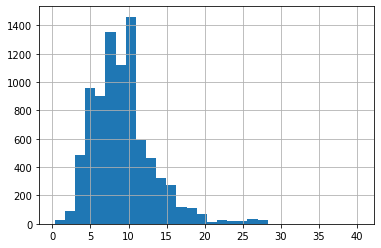

In [132]:
data.n_dist_to_grand_palace.hist(bins=30)

In [133]:
# keep columns if contain d_, n_,f_, p_, usd_ and some others

data = data.filter(regex="^d_.*|^n_.*|^f_.*|^p_.*|^price.*").assign(id = data.id)

### these are for the lasso

In [134]:
# Squares and further values to create
data = data.assign(
    n_accommodates2=lambda x: x["n_accommodates"] ** 2,
    n_dist_to_grand_palace2=lambda x: x["n_dist_to_grand_palace"] ** 2,
    ln_accommodates=lambda x: np.log(x["n_accommodates"]),
    ln_accommodates2=lambda x: np.log(x["n_accommodates"]) ** 2,
    ln_beds=lambda x: np.log(x["n_beds"]),
    ln_number_of_reviews=lambda x: np.log(x["n_number_of_reviews"] + 1),
)

In [135]:
# Pool num of reviews to 3 categories: none, 1-51 and >51

bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 51), (51, max(data.n_number_of_reviews))], closed="left"
)
fnor = pd.cut(data["n_number_of_reviews"].to_list(), bins, labels=["0", "1", "2"])
fnor.categories = [0, 1, 2]
data["f_number_of_reviews"] = fnor
data["f_number_of_reviews"].value_counts(dropna=False)

1      4839
0      2681
2       985
NaN       1
Name: f_number_of_reviews, dtype: int64

In [136]:
# Pool and categorize the number of minimum nights: 1,2,3, 3+

bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, max(data.n_minimum_nights))], closed="left"
)
f_min_n = pd.cut(data["n_minimum_nights"].to_list(), bins, labels=["1", "2", "3"])
f_min_n.categories = [1, 2, 3]
data["f_minimum_nights"] = f_min_n
data["f_minimum_nights"].value_counts(dropna=False)

3      3848
1      3697
2       960
NaN       1
Name: f_minimum_nights, dtype: int64

In [137]:
# Change Infinite values with NaNs
data = data.replace([np.inf, -np.inf], np.nan)

In [138]:
# ------------------------------------------------------------------------------------------------
# where do we have missing variables now?
to_filter = data.isna().sum()
to_filter[to_filter > 0]

n_review_scores_rating    2681
n_reviews_per_month       2681
n_beds                     139
n_days_since              2681
ln_beds                    433
f_number_of_reviews          1
f_minimum_nights             1
dtype: int64

In [139]:
# what to do with missing values?

In [140]:
data.price.isnull().sum()

0

In [141]:
# 2. imput when few, not that important
data = data.assign(
    n_beds=lambda x: np.where(x["n_beds"].isnull(), x["n_accommodates"], x["n_beds"]),
    f_minimum_nights=lambda x: x["f_minimum_nights"].fillna(1),
    f_number_of_reviews=lambda x: x["f_number_of_reviews"].fillna(1),
    ln_beds=lambda x: x["ln_beds"].fillna(0),
)

In [142]:
to_filter = data.isna().sum()
to_filter[to_filter > 0]

n_review_scores_rating    2681
n_reviews_per_month       2681
n_days_since              2681
dtype: int64

In [143]:
# 4. Replace missing variables re reviews with zero, when no review + add flags
data = data.assign(
    flag_days_since=np.multiply(data.n_days_since.isna(), 1),
    n_days_since=data.n_days_since.fillna(np.median(data.n_days_since.dropna())),
    flag_review_scores_rating=np.multiply(data.n_review_scores_rating.isna(), 1),
    n_review_scores_rating=data.n_review_scores_rating.fillna(
        np.median(data.n_review_scores_rating.dropna())
    ),
    flag_reviews_per_month=np.multiply(data.n_reviews_per_month.isna(), 1),
    n_reviews_per_month=data.n_reviews_per_month.fillna(
        np.median(data.n_reviews_per_month.dropna())
    ),
    flag_n_number_of_reviews=np.multiply(data.n_number_of_reviews.isna(), 1),
)

In [144]:
data.flag_days_since.value_counts()

0    5825
1    2681
Name: flag_days_since, dtype: int64

In [145]:
# Create variables, measuring the time since: squared, cubic, logs
data = data.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
)

In [146]:
data.ln_days_since = data["ln_days_since"].fillna(0)
data.ln_days_since2 = data["ln_days_since2"].fillna(0)
data.ln_days_since3 = data["ln_days_since3"].fillna(0)

In [147]:
to_filter = data.isna().sum()
to_filter[to_filter > 0]

Series([], dtype: int64)

In [151]:
data.to_csv("../data/airbnb_bangkok_workfile.csv", index=False)